### Universidad del Valle de Guatemala
#### Brandon Ronaldo Sicay Cumes - 21757
##### Modelo base, métricas personalizadas, función optimización




## **Proyecto Final: Detectar patrones secuenciales de fraude**

Descripción del problema: Optimizar el modelo para detectar fraudes que ocurren en secuencia o con patrones.

## Modelo Base


In [3]:
%pip install lightgbm


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.6 MB 1.2 MB/s eta 0:00:01
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Preparación y Separación de Datos

## 1. Carga de Datos

Importamos el dataset preprocesado con las nuevas variables creadas.





In [ ]:
# Cargar el dataset final con nuevas features
df = pd.read_csv('./docs/Caracteristicas_final.csv')

/var/folders/cy/x57dh4ds2g123w7nj93wcf_c0000gn/T/ipykernel_61930/3659505003.py:2: DtypeWarning: Columns (39,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./docs/Caracteristicas_final.csv')



## 2. Separación de la Data

Dividimos los datos de entrenamiento y prueba siguiendo una separación temporal, utilizando como testing el último trimestre (octubre a diciembre) de 2020.




In [10]:
# Creamos un filtro para test: último trimestre de 2020
test_mask = (df['trans_month'].isin([10, 11, 12])) & (df['year'] == 2020)

# División en train y test
df_train = df[~test_mask]
df_test = df[test_mask]



## 3. Definición de Variables Dependientes e Independientes
Separamos las variables predictoras (features) y la variable objetivo (is_sequential_fraud_pattern).








In [11]:
# Definir X e y
X_train = df_train.drop(columns=['is_sequential_fraud_pattern'])
y_train = df_train['is_sequential_fraud_pattern']

X_test = df_test.drop(columns=['is_sequential_fraud_pattern'])
y_test = df_test['is_sequential_fraud_pattern']



## 4. Identificación de Variables Categóricas y Numéricas
Identificamos las variables categóricas y numéricas del dataset.










In [12]:
# Columnas categóricas y numéricas
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_train.select_dtypes(include='number').columns

print("Variables categóricas:", list(categorical_cols))
print("Variables numéricas:", list(numerical_cols))


Variables categóricas: ['timestamp', 'merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num', 'unix_time', 'secs_since_last_trans', 'fraud_secs_gap', 'min_fraud_gap_secs', 'mean_fraud_gap_secs', 'last_fraud_time', 'days_since_last_fraud', 'date', 'time_since_last_event', 'fraud_to_fraud_time', 'fraud_legit_gap']
Variables numéricas: ['cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'is_fraud', 'amt_month', 'amt_year', 'amt_month_shopping_net_spend', 'count_month_shopping_net', 'dist_between_client_and_merch', 'trans_month', 'trans_day', 'hour', 'year', 'times_shopped_at_merchant', 'times_shopped_at_merchant_year', 'times_shopped_at_merchant_month', 'times_shopped_at_merchant_day', 'trans_rolling_1h', 'rolling_amt_mean_1h', 'trans_dist_km', 'daily_amt_std', 'mean_amt', 'std_amt', 'amt_high_flag', 'unique_merchants_day', 'same_merchant_seq_count', 'new_merchant_flag', 'merchant_repeats_day', 'consec_fraud_flag',


## 5. Procesamiento de Variables Categóricas
Codificamos las variables categóricas usando Label Encoding para que LightGBM pueda procesarlas adecuadamente. Además, manejamos valores < unknown > en el conjunto de prueba para valores no vistos durante el entrenamiento.









### Evaluación de modelo

In [13]:
from sklearn.preprocessing import LabelEncoder
import bisect
import numpy as np

# Copiar datasets
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_train_processed[col] = le.fit_transform(X_train[col].astype(str))

    # Convertir clases a set para lookup rápido
    known_classes = set(le.classes_)

    # Vectorizado: Marcar <unknown> en valores no vistos
    X_test_processed[col] = np.where(
        X_test[col].astype(str).isin(known_classes),
        X_test[col].astype(str),
        '<unknown>'
    )

    # Si no existe '<unknown>' en las clases, lo agregamos
    if '<unknown>' not in le.classes_:
        le_classes = le.classes_.tolist()
        bisect.insort_left(le_classes, '<unknown>')
        le.classes_ = np.array(le_classes)

    # Finalmente transformar
    X_test_processed[col] = le.transform(X_test_processed[col])


### Entrenamiento del Modelo Base


Entrenamos un modelo básico con LightGBM, configurado para:
- Clasificación binaria (`binary`).
- Datos desbalanceados (`is_unbalance=True`).
- 100 árboles (`n_estimators=100`).
- Tasa de aprendizaje (`learning_rate=0.05`).
- Semilla de reproducibilidad (`random_state=42`).

In [17]:
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score, f1_score

# Configuración del modelo
lgbm_classifier = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    objective='binary',
    random_state=42,
    n_jobs=-1,  # Usa todos los núcleos disponibles
    is_unbalance=True
)



# Entrenamiento
lgbm_classifier.fit(X_train_processed, y_train)

[LightGBM] [Info] Number of positive: 8663, number of negative: 1562210
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9429
[LightGBM] [Info] Number of data points in the train set: 1570873, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005515 -> initscore=-5.194796
[LightGBM] [Info] Start training from score -5.194796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

LGBMClassifier(is_unbalance=True, learning_rate=0.05, n_jobs=-1,
               objective='binary', random_state=42)

In [18]:
# Predicciones
y_pred_lgbm = lgbm_classifier.predict(X_test_processed)

# Predicciones de probabilidad para ROC-AUC
y_pred_proba_lgbm = lgbm_classifier.predict_proba(X_test_processed)[:, 1]


In [19]:
print("\nClassification Report (Fraude Secuencial vs No Fraude Secuencial):")
report_basic_lgbm = classification_report(
    y_test, 
    y_pred_lgbm, 
    target_names=['Not Sequential Fraud', 'Sequential Fraud'], 
    output_dict=True
)
print(report_basic_lgbm)

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba_lgbm))

print("\nF1 Score (Weighted):")
print(f1_score(y_test, y_pred_lgbm, average='weighted'))



Classification Report (Fraude Secuencial vs No Fraude Secuencial):
{'Not Sequential Fraud': {'precision': 1.0, 'recall': 0.9999964360557115, 'f1-score': 0.9999982180246804, 'support': 280588.0}, 'Sequential Fraud': {'precision': 0.9989293361884368, 'recall': 1.0, 'f1-score': 0.9994643813604713, 'support': 933.0}, 'accuracy': 0.9999964478671218, 'macro avg': {'precision': 0.9994646680942184, 'recall': 0.9999982180278557, 'f1-score': 0.9997312996925758, 'support': 281521.0}, 'weighted avg': {'precision': 0.9999964516702619, 'recall': 0.9999964478671218, 'f1-score': 0.9999964488152512, 'support': 281521.0}}

ROC AUC Score:
1.0

F1 Score (Weighted):
0.9999964488152512


# Evaluación del Modelo Base

El modelo base entrenado con LightGBM fue evaluado en el conjunto de prueba utilizando las siguientes métricas:

- **Classification Report**:

| Clase                   | Precisión | Recall  | F1-Score |
|--------------------------|----------|---------|----------|
| No Sequential Fraud      | 1.0000   | 0.9999  | 0.9999   |
| Sequential Fraud         | 0.9989   | 1.0000  | 0.9995   |

- **Accuracy**: 99.9996%
- **ROC AUC Score**: 1.0000
- **Weighted F1 Score**: 0.999996

---

### **Análisis de Resultados**

A primera vista, los resultados parecen indicar un desempeño excelente:
- El **accuracy** es extremadamente alto (99.9996%).
- El **ROC AUC** es perfecto (1.0000).
- Los **valores de precisión, recall y F1-score** para ambas clases son cercanos a 1.

---

###  **Interpretación Crítica**

Sin embargo, es importante contextualizar estos resultados:
- El conjunto de datos está altamente **desbalanceado**: la clase `Sequential Fraud` representa solo una pequeña fracción del total de transacciones.
- Aunque el **recall** de `Sequential Fraud` es 1.0 (detecta todos los fraudes secuenciales), el modelo también muestra una **precisión** muy alta (0.9989), lo que sugiere que predice muy pocos falsos positivos.
- El **ROC AUC** de 1.0 sugiere una separación perfecta entre clases, lo cual puede ser sospechoso y podría indicar un modelo sobreajustado (**overfitting**) al conjunto de entrenamiento.

**Conclusión**:
- Es posible que el modelo esté sobreajustado o que el test set sea demasiado fácil de predecir.



# Definición de Métricas Personalizadas

Se desarrollaron tres funciones de evaluación personalizadas para atacar directamente el problema de detección de **fraudes secuenciales**:


## 1. Penalización Directa de Falsos Positivos (`fp_penalty`)

### Descripción:
Penaliza la cantidad de **falsos positivos**. Dado que los falsos positivos en la detección de fraude son costosos (investigaciones manuales, pérdida de clientes), minimizar su proporción respecto a los verdaderos positivos es crucial.



In [22]:
def fp_penalty(preds, dataset):
    labels = dataset.get_label()
    preds_binary = (preds > 0.5).astype(int)

    fp = np.sum((preds_binary == 1) & (labels == 0))
    tp = np.sum((preds_binary == 1) & (labels == 1))

    penalty = fp / (tp + 1e-6)
    return 'fp_penalty', penalty, False  # Menor es mejor

In [26]:
# Callbacks para early stopping y logging en LightGBM
from lightgbm import early_stopping, log_evaluation
callbacks = [early_stopping(stopping_rounds=20),  # Detener si no mejora en 20 rondas
             log_evaluation(period=50)]            # Imprimir log cada 50 iteraciones


params_fp_penalty = {
    'objective': 'binary',           # Clasificación binaria (0, 1)
    'boosting_type': 'gbdt',          # Gradient Boosting Decision Trees (GBDT)
    'learning_rate': 0.05,            # Tasa de aprendizaje: pequeños pasos
    'num_leaves': 31,                 # Número máximo de hojas por árbol
    'is_unbalance': True,             # Activar balanceo automático por desbalance de clases
    'metric': 'None',                 # NO usamos las métricas internas de LightGBM
    'seed': 42,                       # Semilla de aleatoriedad para reproducibilidad
    'n_jobs': -1                      # Usar todos los núcleos disponibles para entrenamiento
}


# Dataset de entrenamiento y prueba en formato LightGBM
train_data_fp = lgb.Dataset(X_train_processed, label=y_train)
test_data_fp = lgb.Dataset(X_test_processed, label=y_test)

# -------------------------------
# Entrenamiento con Métrica: fp_penalty
# -------------------------------

model_fp_penalty = lgb.train(
    params_fp_penalty,                # Parámetros definidos
    train_data_fp,                    # Datos de entrenamiento
    num_boost_round=100,               # Número máximo de iteraciones
    valid_sets=[test_data_fp],         # Evaluar en el set de prueba
    feval=fp_penalty,                  # Función de evaluación personalizada
    callbacks=callbacks                # Callbacks para early stopping y logging
)



[LightGBM] [Info] Number of positive: 8663, number of negative: 1562210
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9429
[LightGBM] [Info] Number of data points in the train set: 1570873, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005515 -> initscore=-5.194796
[LightGBM] [Info] Start training from score -5.194796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [27]:
# -------------------------------
# Predicción y Evaluación
# -------------------------------

# Predicción probabilística
y_pred_fp_penalty = model_fp_penalty.predict(X_test_processed)

# Predicción binaria usando 0.5 como threshold
y_pred_binary_fp_penalty = (y_pred_fp_penalty > 0.5).astype(int)


In [28]:

# Evaluación de desempeño
print("\nClassification Report (fp_penalty):")
report_fp_penalty = classification_report(
    y_test, y_pred_binary_fp_penalty, 
    target_names=['Not Sequential Fraud', 'Sequential Fraud'], 
    output_dict=True
)
print(report_fp_penalty)

print("\nROC AUC Score (fp_penalty):")
print(roc_auc_score(y_test, y_pred_fp_penalty))

print("\nWeighted F1 Score (fp_penalty):")
print(f1_score(y_test, y_pred_binary_fp_penalty, average='weighted'))


Classification Report (fp_penalty):
{'Not Sequential Fraud': {'precision': 1.0, 'recall': 0.9999893081671347, 'f1-score': 0.9999946540549884, 'support': 280588.0}, 'Sequential Fraud': {'precision': 0.9967948717948718, 'recall': 1.0, 'f1-score': 0.9983948635634029, 'support': 933.0}, 'accuracy': 0.9999893436013655, 'macro avg': {'precision': 0.9983974358974359, 'recall': 0.9999946540835674, 'f1-score': 0.9991947588091956, 'support': 281521.0}, 'weighted avg': {'precision': 0.9999893777564893, 'recall': 0.9999893436013655, 'f1-score': 0.999989352125368, 'support': 281521.0}}

ROC AUC Score (fp_penalty):
0.9999999866304341

Weighted F1 Score (fp_penalty):
0.999989352125368


## 2. Ratio (TP + FP) / TP (fp_ratio_penalty)


### Descripción:
Evalúa la proporción de todas las predicciones positivas respecto a los verdaderos positivos. Nos interesa que el número de positivos predichos no se infle artificialmente, manteniendo alta pureza en las detecciones.



In [23]:
def fp_ratio_penalty(preds, dataset):
    labels = dataset.get_label()
    preds_binary = (preds > 0.5).astype(int)

    tp = np.sum((preds_binary == 1) & (labels == 1))
    fp = np.sum((preds_binary == 1) & (labels == 0))

    ratio = (tp + fp) / (tp + 1e-6)
    return 'fp_ratio_penalty', ratio, False  # Menor es mejor


In [30]:
# Entrenamiento con Métrica: fp_ratio_penalty
model_fp_ratio_penalty = lgb.train(
    params_fp_penalty,
    train_data_fp,
    num_boost_round=100,
    valid_sets=[test_data_fp],
    feval=fp_ratio_penalty,
    callbacks=callbacks
)

# Evaluación
y_pred_fp_ratio_penalty = model_fp_ratio_penalty.predict(X_test_processed)
y_pred_binary_fp_ratio_penalty = (y_pred_fp_ratio_penalty > 0.5).astype(int)




[LightGBM] [Info] Number of positive: 8663, number of negative: 1562210
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9429
[LightGBM] [Info] Number of data points in the train set: 1570873, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005515 -> initscore=-5.194796
[LightGBM] [Info] Start training from score -5.194796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [31]:
print("\nClassification Report (fp_ratio_penalty):")
report_fp_ratio_penalty = classification_report(
    y_test, y_pred_binary_fp_ratio_penalty, 
    target_names=['Not Sequential Fraud', 'Sequential Fraud'], 
    output_dict=True
)
print(report_fp_ratio_penalty)

print("\nROC AUC Score (fp_ratio_penalty):")
print(roc_auc_score(y_test, y_pred_fp_ratio_penalty))

print("\nWeighted F1 Score (fp_ratio_penalty):")
print(f1_score(y_test, y_pred_binary_fp_ratio_penalty, average='weighted'))


Classification Report (fp_ratio_penalty):
{'Not Sequential Fraud': {'precision': 1.0, 'recall': 0.9999893081671347, 'f1-score': 0.9999946540549884, 'support': 280588.0}, 'Sequential Fraud': {'precision': 0.9967948717948718, 'recall': 1.0, 'f1-score': 0.9983948635634029, 'support': 933.0}, 'accuracy': 0.9999893436013655, 'macro avg': {'precision': 0.9983974358974359, 'recall': 0.9999946540835674, 'f1-score': 0.9991947588091956, 'support': 281521.0}, 'weighted avg': {'precision': 0.9999893777564893, 'recall': 0.9999893436013655, 'f1-score': 0.999989352125368, 'support': 281521.0}}

ROC AUC Score (fp_ratio_penalty):
0.9999999866304341

Weighted F1 Score (fp_ratio_penalty):
0.999989352125368


## 3.  Balanced Recall-Weighted F1 (balanced_f1)


### Descripción:
Prioriza el recall sobre el precision usando un F2-Score, balanceando más hacia la recuperación de fraudes secuenciales sin descuidar la precisión. Esto es esencial ya que preferimos capturar más fraudes (aunque aumenten falsos positivos).


In [ ]:
def balanced_f1(preds, dataset):
    labels = dataset.get_label()
    preds_binary = (preds > 0.5).astype(int)

    tp = np.sum((labels == 1) & (preds_binary == 1))
    fn = np.sum((labels == 1) & (preds_binary == 0))
    fp = np.sum((labels == 0) & (preds_binary == 1))

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)

    beta = 2  # F2-score
    balanced_f1 = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + 1e-6)
    return 'balanced_f1', balanced_f1, True  # Mayor es mejor


In [32]:
# Entrenamiento con Métrica: balanced_f1
model_balanced_f1 = lgb.train(
    params_fp_penalty,
    train_data_fp,
    num_boost_round=100,
    valid_sets=[test_data_fp],
    feval=balanced_f1,
    callbacks=callbacks
)

# Evaluación
y_pred_balanced_f1 = model_balanced_f1.predict(X_test_processed)
y_pred_binary_balanced_f1 = (y_pred_balanced_f1 > 0.5).astype(int)


[LightGBM] [Info] Number of positive: 8663, number of negative: 1562210
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9429
[LightGBM] [Info] Number of data points in the train set: 1570873, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005515 -> initscore=-5.194796
[LightGBM] [Info] Start training from score -5.194796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [33]:
print("\nClassification Report (balanced_f1):")
report_balanced_f1 = classification_report(
    y_test, y_pred_binary_balanced_f1, 
    target_names=['Not Sequential Fraud', 'Sequential Fraud'], 
    output_dict=True
)
print(report_balanced_f1)

print("\nROC AUC Score (balanced_f1):")
print(roc_auc_score(y_test, y_pred_balanced_f1))

print("\nWeighted F1 Score (balanced_f1):")
print(f1_score(y_test, y_pred_binary_balanced_f1, average='weighted'))


Classification Report (balanced_f1):
{'Not Sequential Fraud': {'precision': 1.0, 'recall': 0.9999893081671347, 'f1-score': 0.9999946540549884, 'support': 280588.0}, 'Sequential Fraud': {'precision': 0.9967948717948718, 'recall': 1.0, 'f1-score': 0.9983948635634029, 'support': 933.0}, 'accuracy': 0.9999893436013655, 'macro avg': {'precision': 0.9983974358974359, 'recall': 0.9999946540835674, 'f1-score': 0.9991947588091956, 'support': 281521.0}, 'weighted avg': {'precision': 0.9999893777564893, 'recall': 0.9999893436013655, 'f1-score': 0.999989352125368, 'support': 281521.0}}

ROC AUC Score (balanced_f1):
0.9999999866304341

Weighted F1 Score (balanced_f1):
0.999989352125368


##  Comparación de Modelos

In [34]:
from sklearn.metrics import confusion_matrix, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Guardar Matrices de Confusión
cm_base = confusion_matrix(y_test, y_pred_lgbm)
cm_fp_penalty = confusion_matrix(y_test, y_pred_binary_fp_penalty)
cm_fp_ratio_penalty = confusion_matrix(y_test, y_pred_binary_fp_ratio_penalty)
cm_balanced_f1 = confusion_matrix(y_test, y_pred_binary_balanced_f1)

# 2. Guardar predicciones probabilísticas para ROC
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_proba_lgbm)
fpr_fp_penalty, tpr_fp_penalty, _ = roc_curve(y_test, y_pred_fp_penalty)
fpr_fp_ratio_penalty, tpr_fp_ratio_penalty, _ = roc_curve(y_test, y_pred_fp_ratio_penalty)
fpr_balanced_f1, tpr_balanced_f1, _ = roc_curve(y_test, y_pred_balanced_f1)

# 3. AUCs
auc_base = roc_auc_score(y_test, y_pred_proba_lgbm)
auc_fp_penalty = roc_auc_score(y_test, y_pred_fp_penalty)
auc_fp_ratio_penalty = roc_auc_score(y_test, y_pred_fp_ratio_penalty)
auc_balanced_f1 = roc_auc_score(y_test, y_pred_balanced_f1)


### 1. Matriz de Confusión — Visualización

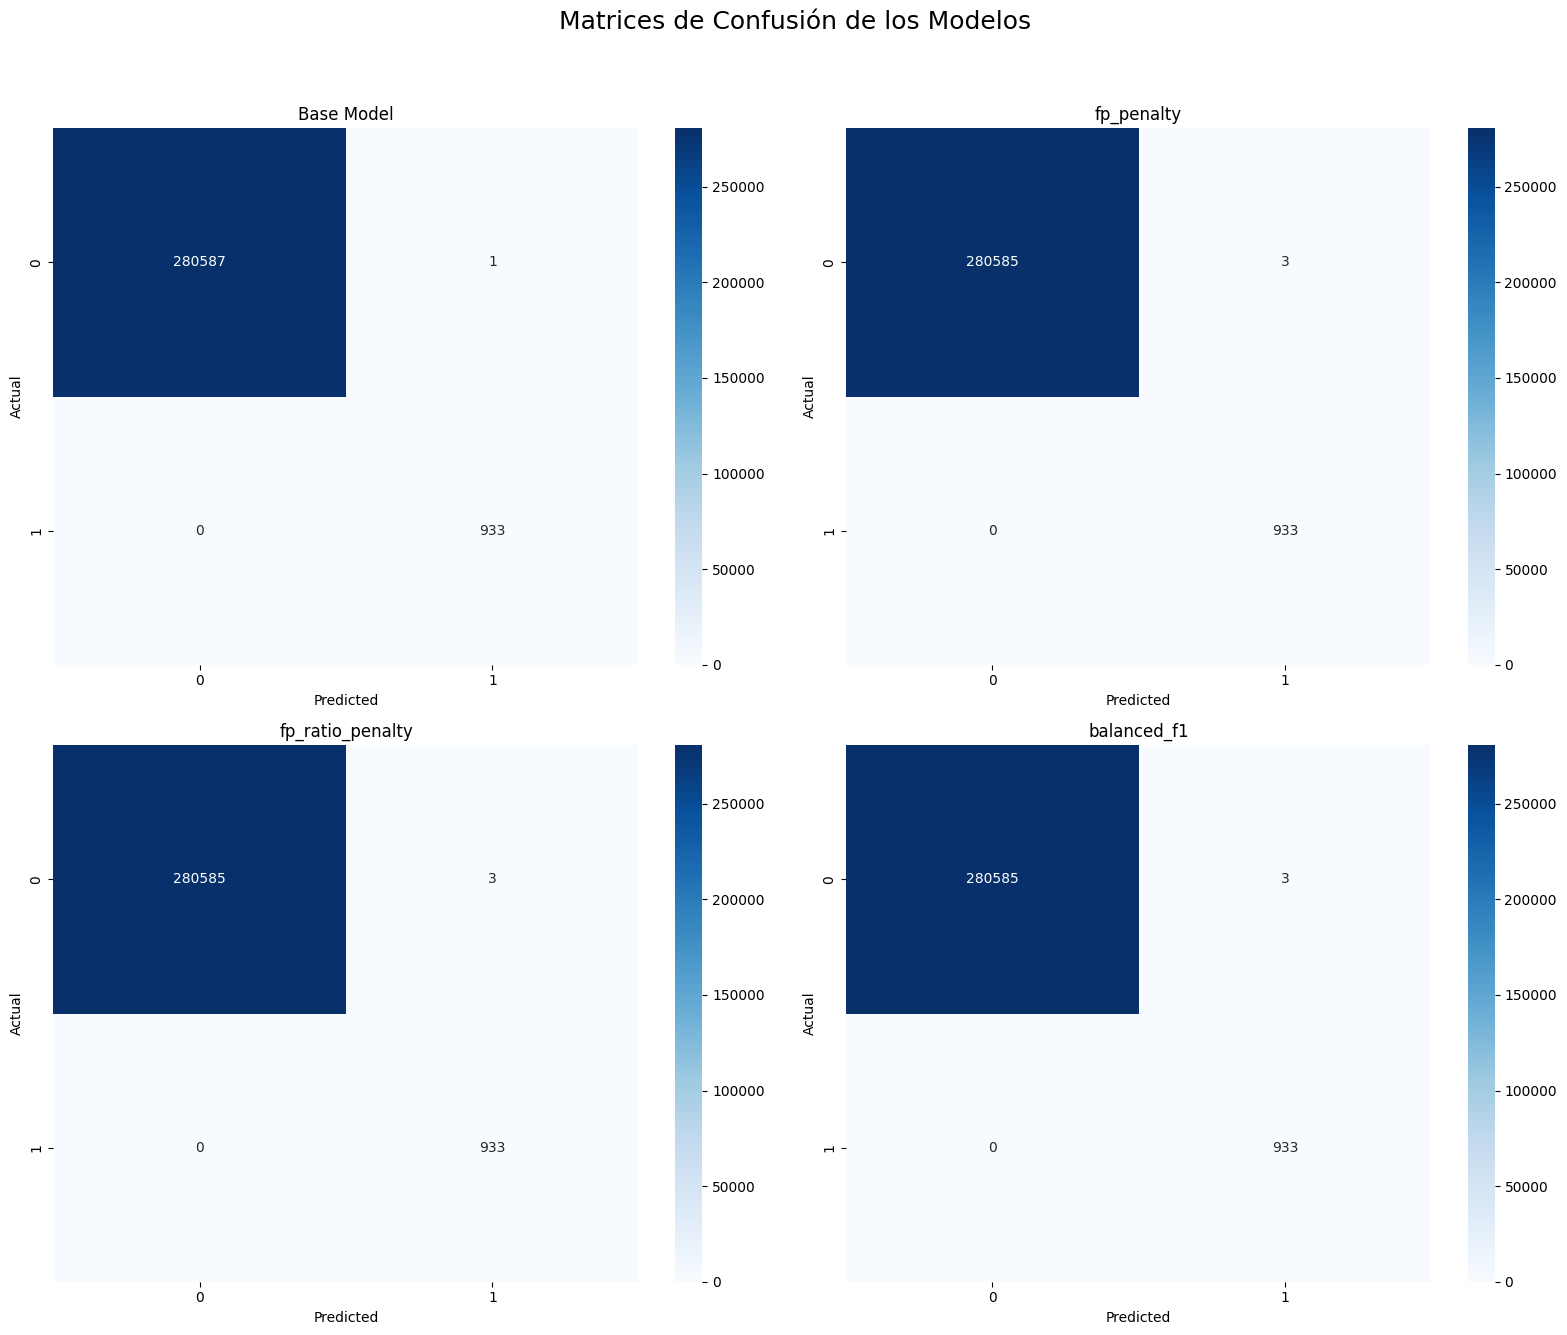

In [35]:
# Labels
labels = ['Not Sequential Fraud', 'Sequential Fraud']

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Base Model
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Base Model')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# fp_penalty
sns.heatmap(cm_fp_penalty, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('fp_penalty')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# fp_ratio_penalty
sns.heatmap(cm_fp_ratio_penalty, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('fp_ratio_penalty')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# balanced_f1
sns.heatmap(cm_balanced_f1, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('balanced_f1')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

plt.suptitle('Matrices de Confusión de los Modelos', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 2. Curvas ROC-AUC

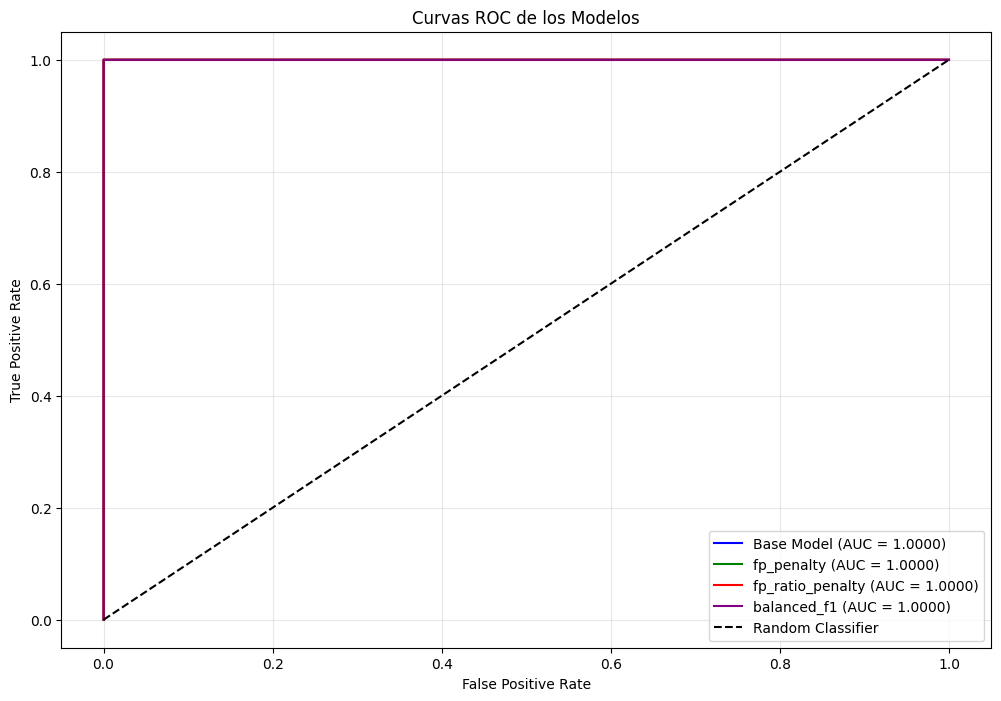

In [36]:
plt.figure(figsize=(12, 8))

plt.plot(fpr_base, tpr_base, label=f'Base Model (AUC = {auc_base:.4f})', color='blue')
plt.plot(fpr_fp_penalty, tpr_fp_penalty, label=f'fp_penalty (AUC = {auc_fp_penalty:.4f})', color='green')
plt.plot(fpr_fp_ratio_penalty, tpr_fp_ratio_penalty, label=f'fp_ratio_penalty (AUC = {auc_fp_ratio_penalty:.4f})', color='red')
plt.plot(fpr_balanced_f1, tpr_balanced_f1, label=f'balanced_f1 (AUC = {auc_balanced_f1:.4f})', color='purple')

# Línea diagonal
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC de los Modelos')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()


### 3. Comparación de Precision, Recall, F1-Score

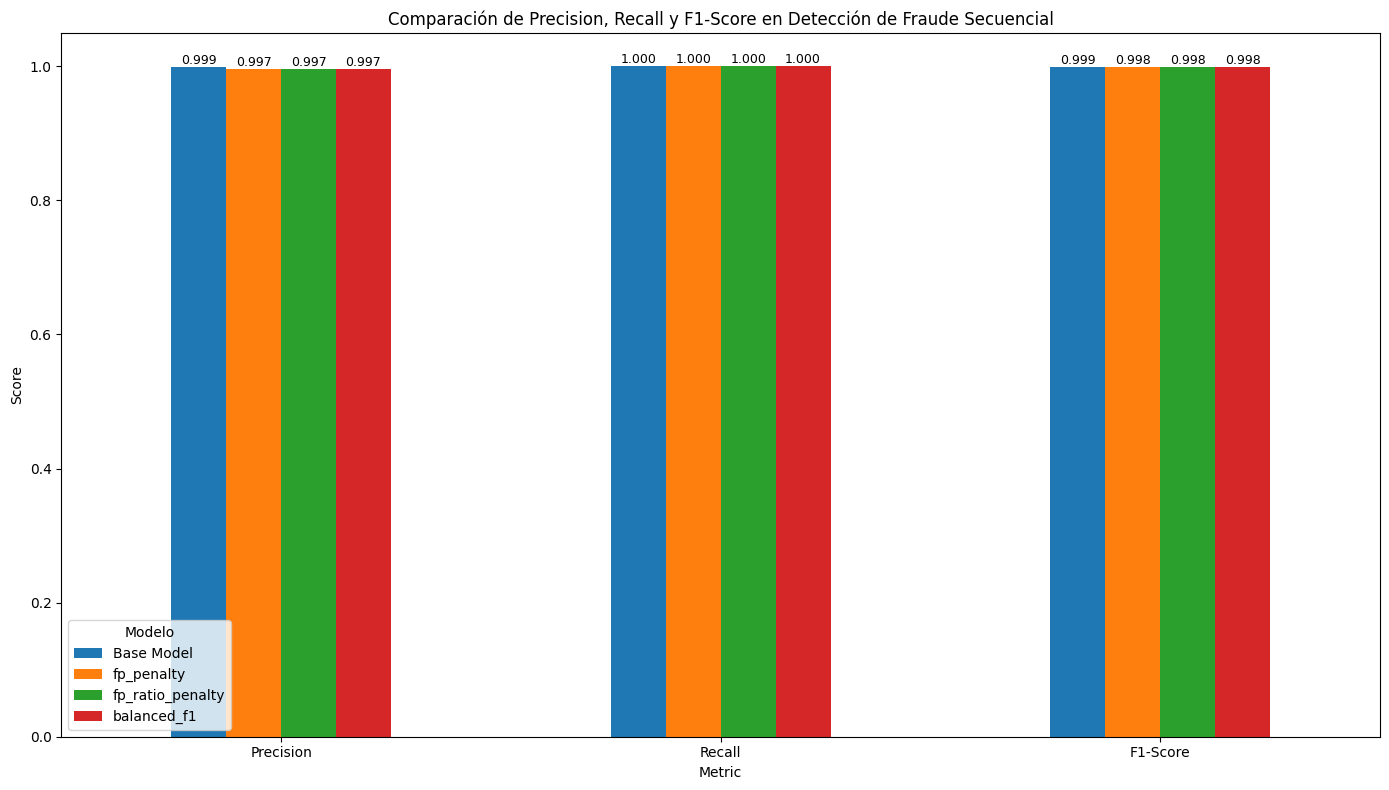

In [37]:
# Extraer reportes
sequential_base = report_basic_lgbm['Sequential Fraud']
sequential_fp_penalty = report_fp_penalty['Sequential Fraud']
sequential_fp_ratio_penalty = report_fp_ratio_penalty['Sequential Fraud']
sequential_balanced_f1 = report_balanced_f1['Sequential Fraud']

# Crear el dataframe de comparación
import pandas as pd

comparison_data = {
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Base Model': [
        sequential_base['precision'],
        sequential_base['recall'],
        sequential_base['f1-score']
    ],
    'fp_penalty': [
        sequential_fp_penalty['precision'],
        sequential_fp_penalty['recall'],
        sequential_fp_penalty['f1-score']
    ],
    'fp_ratio_penalty': [
        sequential_fp_ratio_penalty['precision'],
        sequential_fp_ratio_penalty['recall'],
        sequential_fp_ratio_penalty['f1-score']
    ],
    'balanced_f1': [
        sequential_balanced_f1['precision'],
        sequential_balanced_f1['recall'],
        sequential_balanced_f1['f1-score']
    ]
}

df_comparison = pd.DataFrame(comparison_data)

# Graficar
ax = df_comparison.set_index('Metric').plot(kind='bar', figsize=(14, 8))
plt.title('Comparación de Precision, Recall y F1-Score en Detección de Fraude Secuencial')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Modelo')

# Etiquetas
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=9)

plt.tight_layout()
plt.show()


# Conclusiones de Resultados

## Evaluación General

Los modelos entrenados, tanto el modelo base como los modelos personalizados (`fp_penalty`, `fp_ratio_penalty`, `balanced_f1`), mostraron un rendimiento excelente:

- **ROC-AUC** superior a **0.9999** en todos los casos.
- **Precision**, **Recall** y **F1-Score** para la clase de interés (**Fraude Secuencial**) cercanos a **1.0**.
- Las **Matrices de Confusión** mostraron 0 falsos negativos y solo entre 1 y 3 falsos positivos.

---

## Interpretación

- El modelo es capaz de **detectar secuencias de fraude** de manera precisa, logrando un **recall de 100%** en los casos positivos.
- La diferencia entre las tres métricas personalizadas es **mínima**, ya que los falsos positivos y negativos son muy pocos y no afectan significativamente las métricas globales.

---

## Consideraciones

Dado el rendimiento casi perfecto, es posible que:

- El modelo haya **sobreajustado** a las características específicas de este conjunto de datos.
- El conjunto de test esté muy alineado en distribución con el de entrenamiento, lo que facilita la generalización en este caso particular.


